In [1]:
import requests

def get_weather(api_key, lat, lon):
    url = f"http://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={api_key}&units=metric"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        return None

api_key = 'beecc7f29751e554feb30ab77a4db4ae'
lat = 17.7009  
lon = 83.277   

weather_data = get_weather(api_key, lat, lon)
print(weather_data)


{'coord': {'lon': 83.277, 'lat': 17.7009}, 'weather': [{'id': 502, 'main': 'Rain', 'description': 'heavy intensity rain', 'icon': '10n'}], 'base': 'stations', 'main': {'temp': 26.18, 'feels_like': 26.18, 'temp_min': 26.18, 'temp_max': 26.18, 'pressure': 997, 'humidity': 100, 'sea_level': 997, 'grnd_level': 991}, 'visibility': 3000, 'wind': {'speed': 1.03, 'deg': 0}, 'rain': {'1h': 4.86}, 'clouds': {'all': 100}, 'dt': 1721327323, 'sys': {'type': 1, 'id': 9255, 'country': 'IN', 'sunrise': 1721260862, 'sunset': 1721307889}, 'timezone': 19800, 'id': 1279008, 'name': 'Alipur', 'cod': 200}


In [2]:
if weather_data:
    temperature = weather_data['main']['temp']
    humidity = weather_data['main']['humidity']
    wind_speed = weather_data['wind']['speed']
    weather_description = weather_data['weather'][0]['description']

    print(f"Temperature: {temperature} °C")
    print(f"Humidity: {humidity} %")
    print(f"Wind Speed: {wind_speed} m/s")
    print(f"Weather Description: {weather_description}")
else:
    print("Failed to retrieve weather data.")


Temperature: 26.18 °C
Humidity: 100 %
Wind Speed: 1.03 m/s
Weather Description: heavy intensity rain


In [4]:
import rasterio
import matplotlib.pyplot as plt

image_path = r'C:\Users\educa\Downloads\a2sv/Sentinel2_SR_Export.tif'

with rasterio.open(image_path) as src:
    image = src.read()
    profile = src.profile

print(profile)  



{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 3712, 'height': 3711, 'count': 23, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00026949458523585647, 0.0, 36.49980763517393,
       0.0, -0.00026949458523585647, -0.49991245561251374), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


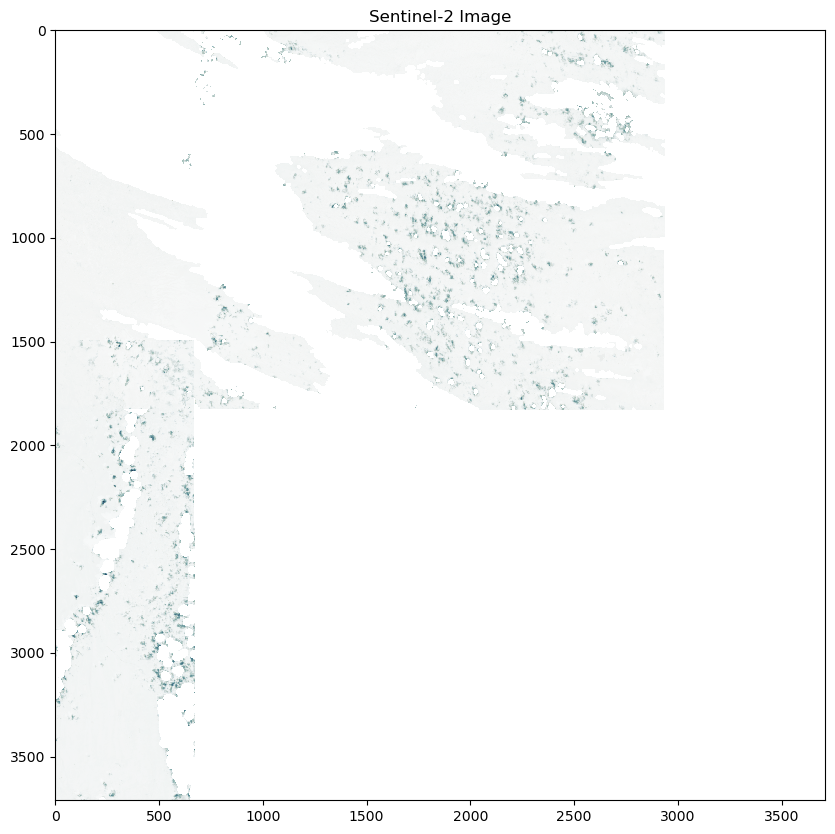

In [5]:
def show_image(image, bands=[3, 2, 1], title='Sentinel-2 Image'):
    plt.figure(figsize=(10, 10))
    plt.imshow(image[bands[0]-1], cmap='Reds', interpolation='none')
    plt.imshow(image[bands[1]-1], cmap='Greens', interpolation='none', alpha=0.6)
    plt.imshow(image[bands[2]-1], cmap='Blues', interpolation='none', alpha=0.6)
    plt.title(title)
    plt.show()

show_image(image)


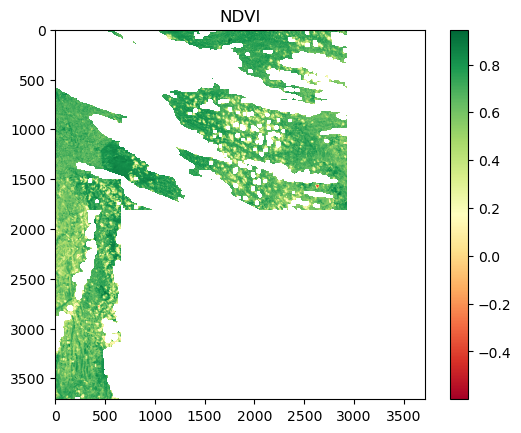

In [6]:
import numpy as np

def calculate_ndvi(nir, red):
    return (nir - red) / (nir + red)

ndvi = calculate_ndvi(image[7], image[3]) 
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI')
plt.show()


c:\Users\educa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


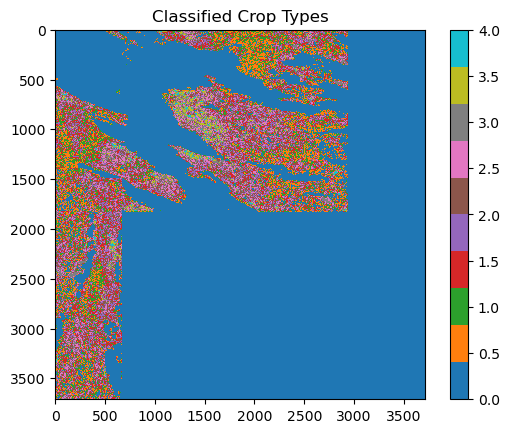

In [8]:
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt


# Reshape the image data for clustering
n_bands, n_rows, n_cols = image.shape
image_2d = image.reshape(n_bands, -1).T

# Handle NaN values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
image_2d_nonan = imputer.fit_transform(image_2d)

# Perform k-means clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(image_2d_nonan)
classified_image = kmeans.labels_.reshape(n_rows, n_cols)

plt.imshow(classified_image, cmap='tab10')
plt.colorbar()
plt.title('Classified Crop Types')
plt.show()


In [10]:
!pip install opencv-python


  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/ec/6c/fab8113424af5049f85717e8e527ca3773299a3c6b02506e66436e19874f/opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata
  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)


In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Function to load and preprocess data
def load_and_preprocess_data(data_dir):
    images = []
    labels = []
    label_map = {
        "Apple___Apple_scab": 0, 
        "Apple___Black_rot": 1, 
        "Apple___Cedar_apple_rust": 2, 
        "Apple___healthy": 3,
      
    }
    
    for label in os.listdir(data_dir):
        for img_file in os.listdir(os.path.join(data_dir, label)):
            img_path = os.path.join(data_dir, label, img_file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (128, 128))
            img = img / 255.0
            images.append(img)
            labels.append(label_map[label])
    
    images = np.array(images)
    labels = np.array(labels)
    return train_test_split(images, labels, test_size=0.2, random_state=42)

# the path to  folder
data_dir = r'C:\Users\educa\Downloads\Compressed\archive_6\plantvillage dataset\color'

# Load and preprocess data
X_train, X_test, y_train, y_test = load_and_preprocess_data(data_dir)

# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")


c:\Users\educa\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 33s 344ms/step - accuracy: 0.5974 - loss: 1.0358 - val_accuracy: 0.8283 - val_loss: 0.4280
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 28s 345ms/step - accuracy: 0.8614 - loss: 0.3765 - val_accuracy: 0.8913 - val_loss: 0.3288
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 25s 307ms/step - accuracy: 0.9054 - loss: 0.2519 - val_accuracy: 0.9039 - val_loss: 0.2636
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 27s 332ms/step - accuracy: 0.9270 - loss: 0.1994 - val_accuracy: 0.8803 - val_loss: 0.3523
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 360ms/step - accuracy: 0.9401 - loss: 0.1635 - val_accuracy: 0.9150 - val_loss: 0.2843
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 25s 314ms/step - accuracy: 0.9481 - loss: 0.1369 - val_accuracy: 0.9228 - val_loss: 0.2225
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 25s 312ms/step - accuracy: 0.9634 - loss: 0.0937 - val_accuracy: 0.9165 - val_loss: 0.2823
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 26s 324ms/step - accuracy: 0.9656 - loss: 0.1130 - val_accu

In [8]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [9]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'C:\Users\educa\Downloads\Compressed\archive_8\PlantVillage',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [11]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [12]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


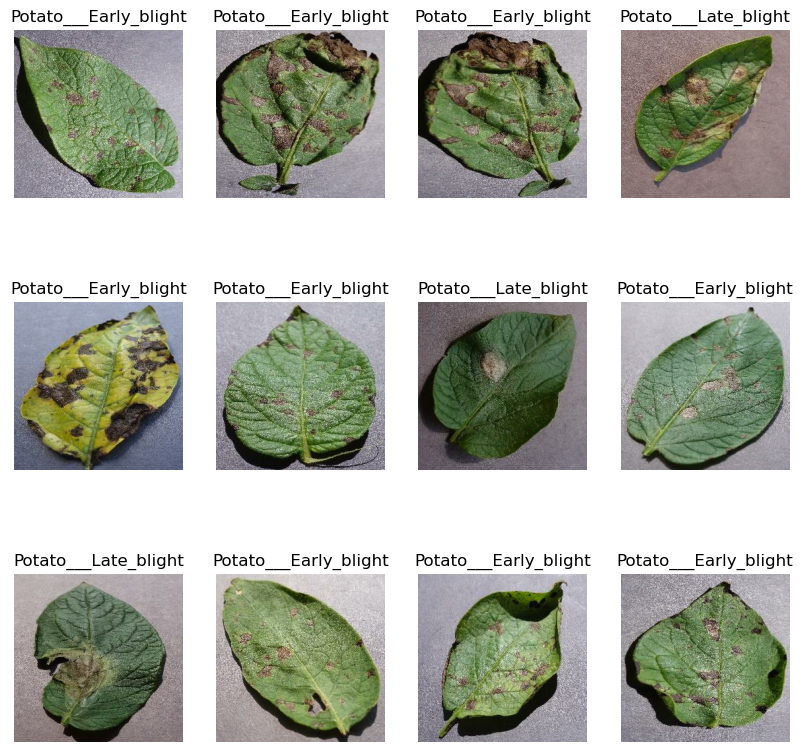

In [13]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [14]:
len(dataset)


68

In [15]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [16]:
train_ds = dataset.take(54)
len(train_ds)

54

In [17]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [18]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [19]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [20]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [23]:
len(train_ds)


54

In [24]:
len(val_ds)

6

In [25]:
len(test_ds)

8

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
import tensorflow as tf
from tensorflow.keras import layers

IMAGE_SIZE = 128  # Adjust to your desired image size

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])


In [31]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


In [32]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

c:\Users\educa\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (32, 128, 128, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 126, 126, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 63, 63, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 61, 61, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (32, 0, 0, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (32, 0, 0, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (32, 0)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (32, 64)               │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,363 (653.76 KB)

 Trainable params: 167,363 (653.76 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [50]:



# Assuming train_ds and val_ds are TensorFlow datasets or numpy arrays
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)


(32, 256, 256, 3)
(32,)


In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=50
)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.5572 - loss: 92.4529 - val_accuracy: 0.7552 - val_loss: 0.5774
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.7858 - loss: 0.6331 - val_accuracy: 0.6615 - val_loss: 0.7220
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.7380 - loss: 0.7430 - val_accuracy: 0.7604 - val_loss: 0.6072
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.7797 - loss: 0.5616 - val_accuracy: 0.8542 - val_loss: 0.3986
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.8567 - loss: 0.4024 - val_accuracy: 0.8906 - val_loss: 0.3225
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.8962 - loss: 0.2781 - val_accuracy: 0.8698 - val_loss: 0.3762
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.9003 - loss: 0.2728 - val_accuracy: 0.8750 - val_loss: 0.3581
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.9179 - loss: 0.1977 - val_accuracy: 0.9323 - v

In [52]:
scores = model.evaluate(test_ds)


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 302ms/step - accuracy: 0.9806 - loss: 0.0729


In [53]:
scores

[0.0993802547454834, 0.96875]

In [54]:
history

In [55]:
history.params


{'verbose': 1, 'epochs': 50, 'steps': 54}

In [56]:
history.history.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [57]:
type(history.history['loss'])


list

In [58]:

len(history.history['loss'])


50

In [59]:
history.history['loss'][:5] # show loss for first 5 epochs


[28.836580276489258,
 0.9911980032920837,
 0.8312692046165466,
 0.49267634749412537,
 0.3666570782661438]

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

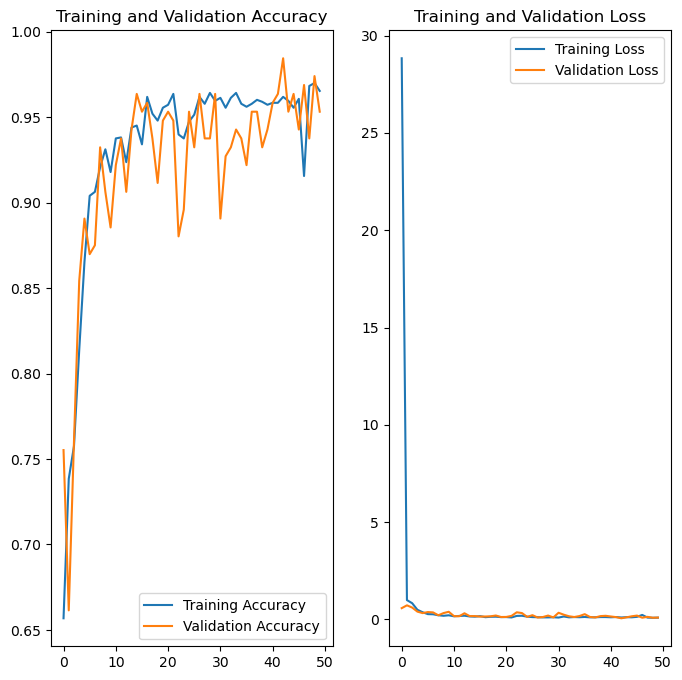

In [61]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
predicted label: Potato___Early_blight


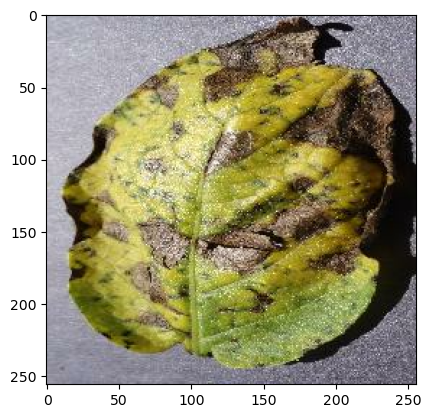

In [62]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [63]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


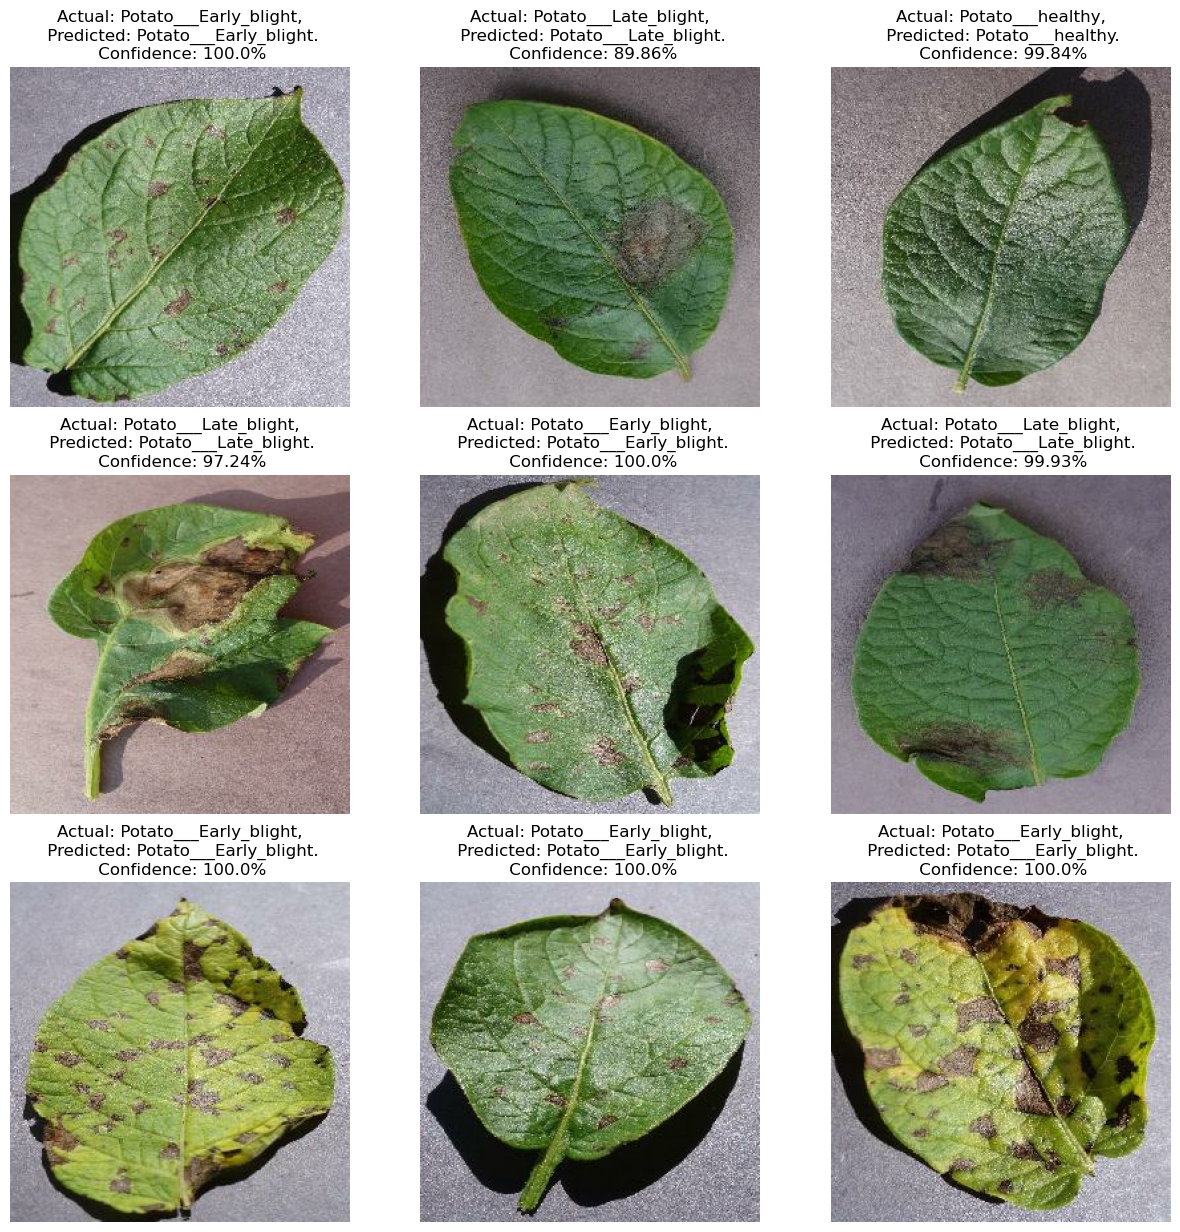

In [64]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")